In [1]:
import torch
from torch_geometric.utils import remove_self_loops, coalesce
from GAE import Encoder, Decoder, GAE
from torchinfo import summary
from torch_geometric.data import Data
import numpy as np
import torch.optim as optim
import scipy
import os
import Get_data as Gd
from sklearn.model_selection import train_test_split
import torch.nn as nn

from tqdm import tqdm  
import matplotlib.pyplot as plt

In [2]:
# 检查是否有 GPU 可用
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

# 检查 GPU 的数量
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# 获取每个 GPU 的名称
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# 设置默认使用的 GPU 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU is available
Number of GPUs available: 1
GPU 0: NVIDIA RTX A6000
Using device: cuda:0


In [3]:
directory = '/data/Sibo_22Mar2024'
folders = [os.path.join(directory, f, 'hessian_') for f in os.listdir(directory) if f.startswith('case_')]

# Get data

In [4]:
xyfile = "/data/Sibo_22Mar2024/case_0/hessian_/xy_coords.npy"
pos = torch.tensor(np.load(xyfile), dtype=torch.float32)

In [5]:
sparse_graph = scipy.sparse.load_npz('/data/Sibo_22Mar2024/sparse_matrix_fixed.npz')
indices = np.array(sparse_graph.nonzero())
values = sparse_graph.data
shape = sparse_graph.shape

# sparse edge tensor
edge_tensor = torch.sparse_coo_tensor(indices, values, shape, dtype=torch.float).coalesce()
edge_index = edge_tensor.indices()
edge_weight = edge_tensor.values()
print(edge_tensor.shape)
print(edge_index)
print(edge_weight)

torch.Size([97149, 97149])
tensor([[    0,     0,     1,  ..., 97148, 97148, 97148],
        [    1,     3,     0,  ..., 97145, 97146, 97147]])
tensor([1., 1., 1.,  ..., 1., 1., 1.])


In [6]:
lengthscales = [0.17, 1]  # 例如定义的长度比例
num_mp_layers = [2, 3]  # 例如定义的消息传递层数

bounding_box = []
if len(lengthscales) > 0:
    x_lo = pos[:,0].min() - lengthscales[0]/2
    x_hi = pos[:,0].max() + lengthscales[0]/2
    y_lo = pos[:,1].min() - lengthscales[0]/2
    y_hi = pos[:,1].max() + lengthscales[0]/2
    bounding_box = [x_lo.cpu(), x_hi.cpu(), y_lo.cpu(), y_hi.cpu()]

## Train and val data

In [7]:
dataset, length = Gd.get_all_nodes(folders[:-1])

train_np, val_np = train_test_split(dataset, test_size=0.2, shuffle=True)
train_np = np.expand_dims(train_np[:, :, 0], axis=2)
val_np = np.expand_dims(val_np[:, :, 0], axis=2)

In [8]:
train_tensor = torch.tensor(train_np, dtype=torch.float)
train_tensor_set = Gd.MyDataset(train_tensor)
val_tensor = torch.tensor(val_np, dtype=torch.float)
val_tensor_set = Gd.MyDataset(val_tensor)

## Test data

In [9]:
test_np, length = Gd.get_all_nodes(folders[-1:])
test_np = np.expand_dims(test_np[:, :, 0], axis=2)
test_tensor = torch.tensor(test_np, dtype=torch.float)
test_tensor_set = Gd.MyDataset(test_tensor)

# Train

In [10]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

In [11]:
def train(model, train_set, val_set, edge_index, edge_attr, pos, criterion, optimizer, device, epochs=30):
    edge_index, edge_attr, pos = edge_index.to(device), edge_attr.to(device), pos.to(device)
    for i in range(epochs):
        model.train()
        train_loss = 0
        for x in tqdm(train_set):
            x = x.to(device)
            optimizer.zero_grad()
            predict, _, _ = model(x, edge_index, edge_attr, pos)
            # print(predict.max(), predict.min())
            loss = criterion(x, predict)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss = train_loss/len(train_set)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            for x in val_set:
                x = x.to(device)
                predict, _, _ = model(x, edge_index, edge_attr, pos)
                loss = criterion(x, predict)
                val_loss += loss.item()
        val_loss /= len(val_set)

        print(f'Epoch {i + 1}/{epochs}, train Loss: {train_loss}, val Loss: {val_loss}')

In [12]:
model = GAE(1, 1, bounding_box, lengthscales, num_mp_layers, 16, 2)
summary(model, input_data=(train_tensor[0], edge_index, edge_weight, pos))

Layer (type:depth-idx)                             Output Shape              Param #
GAE                                                [97149, 1]                --
├─Encoder: 1-1                                     [49, 16]                  --
│    └─ModuleList: 2-3                             --                        (recursive)
│    │    └─Linear: 3-1                            [97149, 16]               32
│    └─ELU: 2-2                                    [97149, 16]               --
│    └─ModuleList: 2-3                             --                        (recursive)
│    │    └─Linear: 3-2                            [97149, 16]               272
│    └─ELU: 2-4                                    [97149, 16]               --
│    └─ModuleList: 2-23                            --                        (recursive)
│    │    └─ModuleList: 3-4                        --                        (recursive)
│    └─ELU: 2-6                                    [97149, 16]               -

In [13]:
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters())
model.to(device)
train(model, train_tensor_set, val_tensor_set, edge_index, edge_weight, pos, criterion, optimizer,device)

100%|██████████| 2320/2320 [01:40<00:00, 23.15it/s]


Epoch 1/30, train Loss: 4.339792572899626, val Loss: 4.197735041585462


100%|██████████| 2320/2320 [01:38<00:00, 23.51it/s]


Epoch 2/30, train Loss: 3.9226566888905805, val Loss: 3.9436617704301047


100%|██████████| 2320/2320 [01:38<00:00, 23.54it/s]


Epoch 3/30, train Loss: 3.836328733866585, val Loss: 3.8565505336584716


100%|██████████| 2320/2320 [01:39<00:00, 23.38it/s]


Epoch 4/30, train Loss: 3.764848928359048, val Loss: 3.825547058674796


100%|██████████| 2320/2320 [01:38<00:00, 23.54it/s]


Epoch 5/30, train Loss: 3.695388857198173, val Loss: 3.785107552902452


100%|██████████| 2320/2320 [01:38<00:00, 23.53it/s]


Epoch 6/30, train Loss: 3.6410654284060002, val Loss: 3.7259703070952974


100%|██████████| 2320/2320 [01:39<00:00, 23.37it/s]


Epoch 7/30, train Loss: 3.589314757621494, val Loss: 3.6536674452752904


100%|██████████| 2320/2320 [01:38<00:00, 23.54it/s]


Epoch 8/30, train Loss: 3.5446981128305195, val Loss: 3.5910834088921546


100%|██████████| 2320/2320 [01:38<00:00, 23.51it/s]


Epoch 9/30, train Loss: 3.4969174985998666, val Loss: 3.5505789941754835


100%|██████████| 2320/2320 [01:39<00:00, 23.35it/s]


Epoch 10/30, train Loss: 3.443146888166666, val Loss: 3.50717306013765


100%|██████████| 2320/2320 [01:38<00:00, 23.54it/s]


Epoch 11/30, train Loss: 3.3947781550087806, val Loss: 3.493962531665276


100%|██████████| 2320/2320 [01:38<00:00, 23.51it/s]


Epoch 12/30, train Loss: 3.3513062977199923, val Loss: 3.4910051141319602


100%|██████████| 2320/2320 [01:39<00:00, 23.34it/s]


Epoch 13/30, train Loss: 3.319084619730711, val Loss: 3.45110906090202


100%|██████████| 2320/2320 [01:38<00:00, 23.52it/s]


Epoch 14/30, train Loss: 3.282790461208286, val Loss: 3.388993963907505


100%|██████████| 2320/2320 [01:38<00:00, 23.56it/s]


Epoch 15/30, train Loss: 3.248211217144954, val Loss: 3.342966015996604


100%|██████████| 2320/2320 [01:39<00:00, 23.31it/s]


Epoch 16/30, train Loss: 3.2153745471275057, val Loss: 3.3216412579704975


100%|██████████| 2320/2320 [01:05<00:00, 35.40it/s]


Epoch 17/30, train Loss: 3.187998446192721, val Loss: 3.2801304808464544


100%|██████████| 2320/2320 [00:35<00:00, 64.90it/s]


Epoch 18/30, train Loss: 3.1563409143866137, val Loss: 3.246451107232735


100%|██████████| 2320/2320 [00:35<00:00, 65.00it/s]


Epoch 19/30, train Loss: 3.1247018429482805, val Loss: 3.1948462074686743


100%|██████████| 2320/2320 [00:35<00:00, 64.99it/s]


Epoch 20/30, train Loss: 3.0969799161856546, val Loss: 3.163218274918096


100%|██████████| 2320/2320 [00:35<00:00, 64.91it/s]


Epoch 21/30, train Loss: 3.071137170789057, val Loss: 3.1374712967153253


100%|██████████| 2320/2320 [00:35<00:00, 64.93it/s]


Epoch 22/30, train Loss: 3.047818692516664, val Loss: 3.1178035056796567


100%|██████████| 2320/2320 [00:35<00:00, 65.03it/s]


Epoch 23/30, train Loss: 3.027781444209917, val Loss: 3.094667763185912


100%|██████████| 2320/2320 [00:35<00:00, 65.14it/s]


Epoch 24/30, train Loss: 3.003728896058325, val Loss: 3.076066089190286


100%|██████████| 2320/2320 [00:36<00:00, 63.82it/s]


Epoch 25/30, train Loss: 2.9809583829266244, val Loss: 3.068437004037972


100%|██████████| 2320/2320 [00:36<00:00, 63.43it/s]


Epoch 26/30, train Loss: 2.957317002618621, val Loss: 3.0482805263893358


100%|██████████| 2320/2320 [00:36<00:00, 63.46it/s]


Epoch 27/30, train Loss: 2.9312141428605236, val Loss: 3.0124081456969525


100%|██████████| 2320/2320 [00:36<00:00, 64.15it/s]


Epoch 28/30, train Loss: 2.9073760669036157, val Loss: 3.003052286444039


100%|██████████| 2320/2320 [00:35<00:00, 64.90it/s]


Epoch 29/30, train Loss: 2.877118654292205, val Loss: 3.001640728167419


100%|██████████| 2320/2320 [00:35<00:00, 64.50it/s]


Epoch 30/30, train Loss: 2.861809621725617, val Loss: 2.99326028520691


In [14]:
torch.save(model.state_dict(), 'GAE.pth')

In [12]:
def draw_pic(x, y, coords):


    fig1, axs = plt.subplots(1, 5, figsize=(30, 6))
    for i in range(5):
        axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=x[i], cmap='bwr')
        axs[i].set_title('input')
    plt.show()
    plt.close()


    fig2, axs = plt.subplots(1, 5, figsize=(30, 6))
    for i in range(5):
        axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=y[i], cmap='bwr')
        axs[i].set_title('recon')
    
    plt.show()
    plt.close()

In [13]:
gae = GAE(1, 1, bounding_box, lengthscales, num_mp_layers, 16, 2)
criterion = RMSELoss()
# 加载保存的状态字典
state_dict = torch.load('GAE.pth')
gae.load_state_dict(state_dict)

<All keys matched successfully>

In [16]:
gae.eval()
with torch.no_grad():
    test_loss = 0
    for x in tqdm(test_tensor_set):
        predict, _, _ = gae(x, edge_index, edge_weight, pos)
        loss = criterion(x, predict)
        test_loss += loss.item()
test_loss /= len(test_tensor_set)
print(f"test loss: {test_loss}")
    

100%|██████████| 100/100 [00:08<00:00, 11.76it/s]

test loss: 11.182663860321044


loss: 11.240548133850098


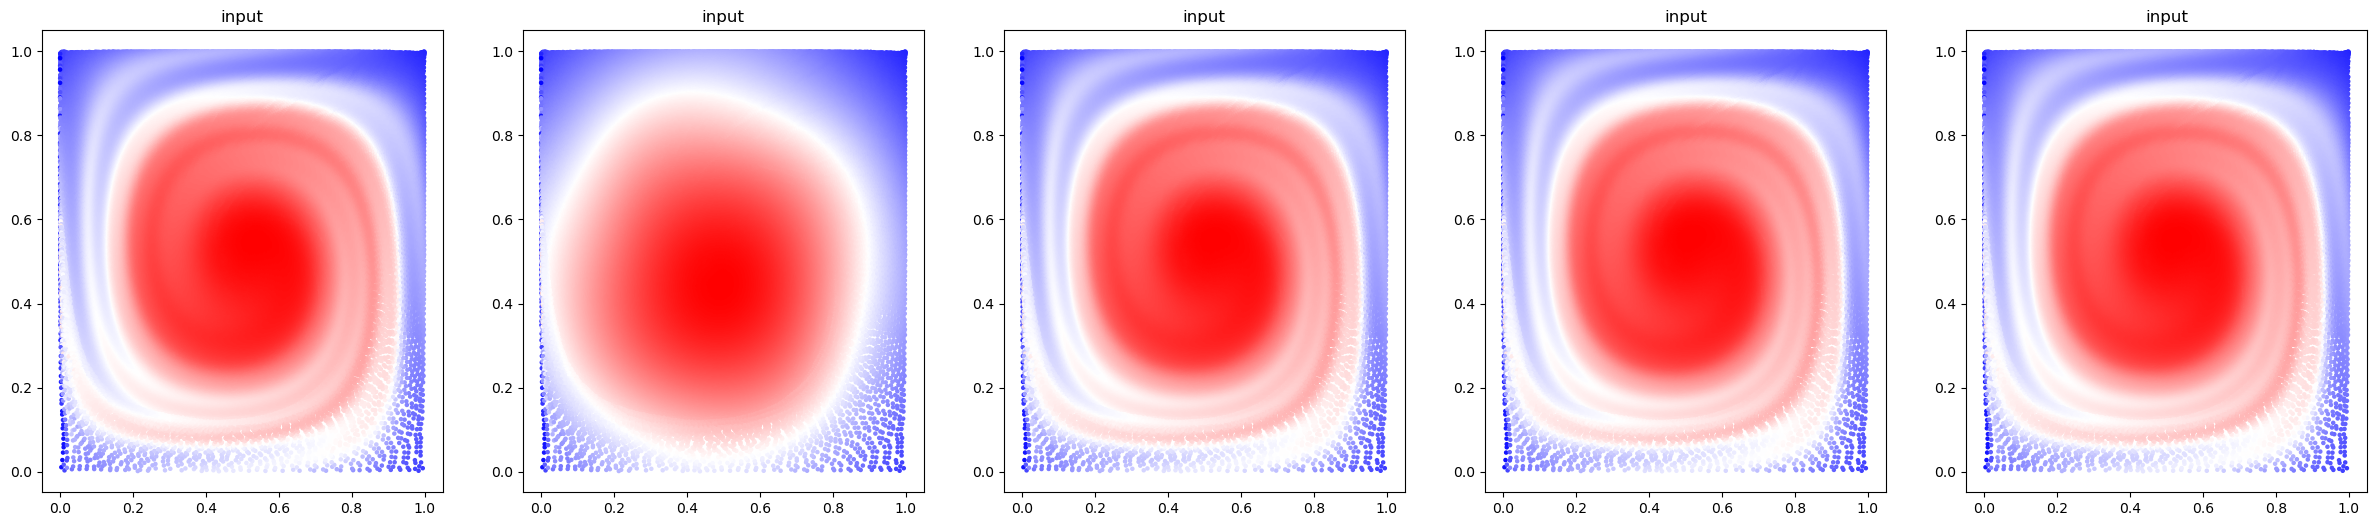

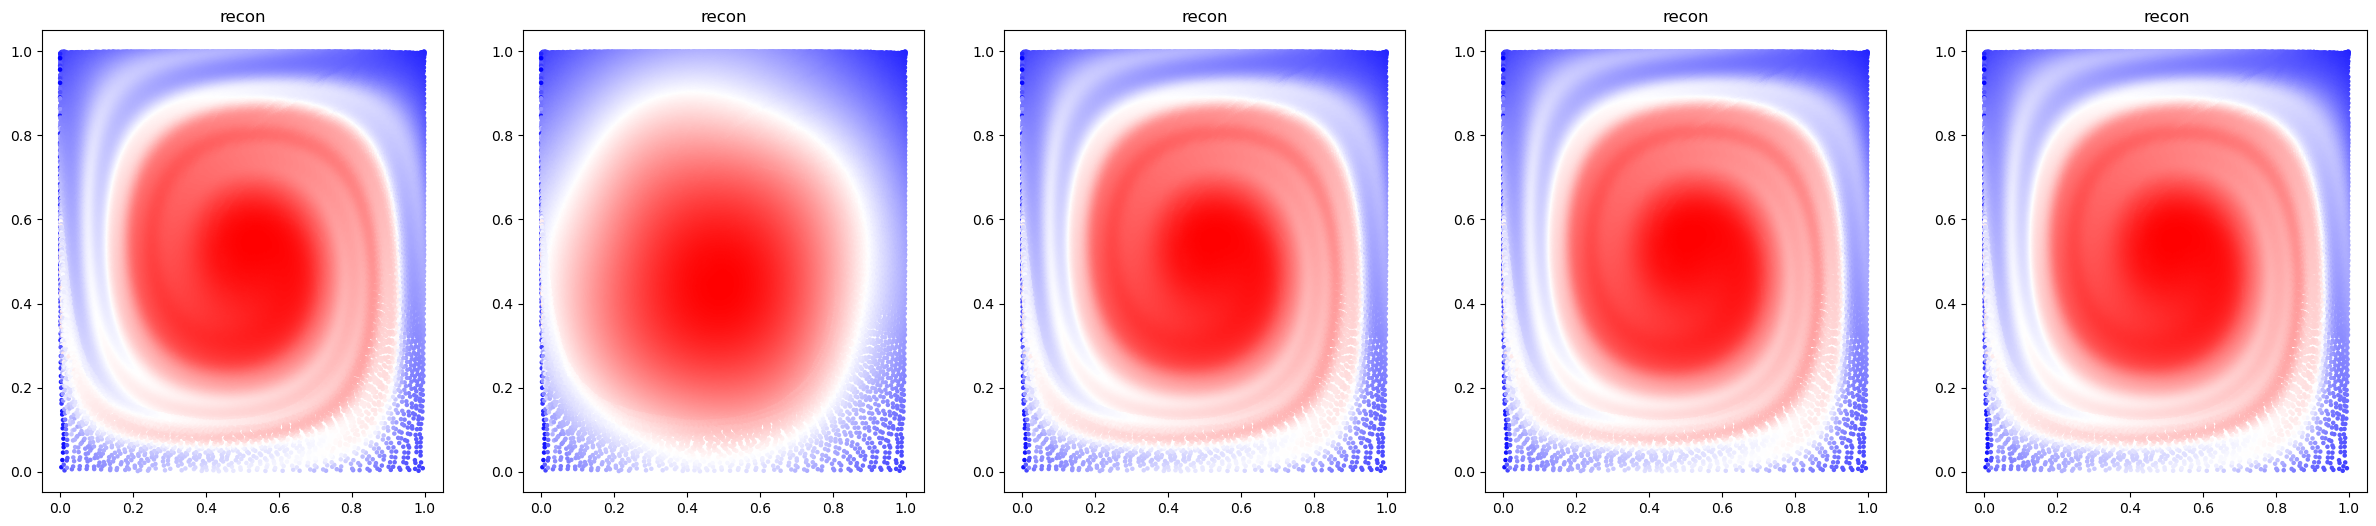

In [17]:
x = test_tensor_set[0:5]
recon_x = torch.zeros_like(x)
for i in range(5):
    recon_x[i], _, _ = gae(x[i], edge_index, edge_weight, pos)

print(f'loss: {criterion(x, recon_x)}')

x_np = x.cpu().detach().numpy()
recon_x_np = x.cpu().detach().numpy()
pos_np = pos.cpu().detach().numpy()
draw_pic(x_np, recon_x_np, pos_np)